In [ ]:
# Instalación de librerías:

!pip install shap
# !pip install tensorflow
!pip install optuna
# !pip install joblib

In [ ]:
# Importamos las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import optuna
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
#from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler#, NearMiss
from sklearn.model_selection import cross_validate, cross_val_predict






In [ ]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df_original = pd.read_csv(file_path, sep=',',engine='python')

# **2. Análisis descriptivo.**


In [ ]:
# Hacemos primero el filtrado por las ubicaciones de interés para poder tomar decisiones dentro de este dataset y no del general
# Lista de ubicaciones de interés. Agregamos Tuggeranong porque está a 15 km en linea recta de Canberra y podemos utilizar sus datos para completar los incompletos
ubicaciones_permitidas = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport','Tuggeranong']

# Filtramos el DataFrame para quedarnos solo con las ubicaciones permitidas
df = df_original[df_original['Location'].isin(ubicaciones_permitidas)]

### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
30168,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
30169,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
30170,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
30171,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


In [ ]:
# Descripción general del conjunto de datos
df.info()
# Las variables de tipo object que son categóricas y las int64 y float64 que son numéricas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19024 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        19024 non-null  int64  
 1   Date              19024 non-null  object 
 2   Location          19024 non-null  object 
 3   MinTemp           18532 non-null  float64
 4   MaxTemp           18534 non-null  float64
 5   Rainfall          18196 non-null  float64
 6   Evaporation       14280 non-null  float64
 7   Sunshine          14038 non-null  float64
 8   WindGustDir       17525 non-null  object 
 9   WindGustSpeed     17527 non-null  float64
 10  WindDir9am        17684 non-null  object 
 11  WindDir3pm        18687 non-null  object 
 12  WindSpeed9am      18740 non-null  float64
 13  WindSpeed3pm      18755 non-null  float64
 14  Humidity9am       18434 non-null  float64
 15  Humidity3pm       18486 non-null  float64
 16  Pressure9am       18274 non-null  fl

In [ ]:
# Obtenemos estadísticas descriptivas de las variables numéricas.
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,19024.000000,18532.000000,18534.000000,18196.000000,14280.000000,14038.000000,17527.000000,18740.000000,18755.000000,18434.000000,18486.000000,18274.000000,18287.000000,13309.000000,13054.000000,18499.000000,18515.000000,18196.000000
mean,49676.924832,10.890908,21.591006,2.280853,4.866828,6.854694,42.844012,15.172359,20.686217,69.544754,50.610408,1018.338886,1015.996593,4.750545,4.746131,15.061787,20.097796,2.279886
std,13917.724927,6.150389,6.225648,7.426650,3.069869,3.842419,14.812441,10.398961,9.416280,15.650404,17.738152,7.430525,7.260106,2.728329,2.589879,5.733912,6.041673,7.426031
min,30176.000000,-8.200000,2.600000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.000000,0.000000,0.000000,-3.100000,2.300000,0.000000
25%,34932.750000,7.100000,16.800000,0.000000,2.600000,3.700000,31.000000,7.000000,13.000000,59.000000,38.000000,1013.400000,1011.100000,2.000000,2.000000,11.100000,15.500000,0.000000
50%,48747.500000,11.000000,21.100000,0.000000,4.200000,7.500000,41.000000,13.000000,20.000000,70.000000,50.000000,1018.500000,1016.100000,6.000000,6.000000,15.000000,19.700000,0.000000
75%,65634.250000,15.300000,25.800000,0.800000,6.600000,10.000000,52.000000,20.000000,26.000000,81.000000,62.000000,1023.400000,1020.900000,7.000000,7.000000,19.100000,24.200000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,119.400000


In [ ]:
# Obtenemos la frecuencia para cada una de las variables categóricas
# df['Date'].value_counts()
print('Location:')
print(df['Location'].value_counts())
print('\nWindGustDir:')
print(df['WindGustDir'].value_counts())
print('\nWindDir9am:')
print(df['WindDir9am'].value_counts())
print('\nWindDir3pm:')
print(df['WindDir3pm'].value_counts())
print('\nRainToday:')
print(df['RainToday'].value_counts())
print('\nRainTomorrow:')
print(df['RainTomorrow'].value_counts())


Location:
Canberra            3435
Sydney              3343
Melbourne           3192
Tuggeranong         3038
SydneyAirport       3008
MelbourneAirport    3008
Name: Location, dtype: int64

WindGustDir:
N      2522
S      1876
SSE    1424
W      1395
NW     1336
WNW    1181
SSW    1059
NNW     966
ENE     943
WSW     868
NE      796
NNE     734
SW      732
E       711
SE      520
ESE     462
Name: WindGustDir, dtype: int64

WindDir9am:
N      2714
W      2305
WNW    1491
NW     1483
S      1195
NNW    1165
SSW    1122
WSW    1073
SW      953
SSE     953
SE      749
NNE     688
ESE     476
E       473
NE      451
ENE     393
Name: WindDir9am, dtype: int64

WindDir3pm:
S      2179
N      1740
NW     1510
WNW    1494
SSE    1459
NNW    1403
E      1135
W      1105
NE     1099
ENE     952
SSW     943
SE      901
WSW     809
ESE     736
NNE     673
SW      549
Name: WindDir3pm, dtype: int64

RainToday:
No     14070
Yes     4126
Name: RainToday, dtype: int64

RainTomorrow:
No     14072
Yes  

In [ ]:
### Cantidad de valores faltantes de todas las columnas del dataset.

df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              492
MaxTemp              490
Rainfall             828
Evaporation         4744
Sunshine            4986
WindGustDir         1499
WindGustSpeed       1497
WindDir9am          1340
WindDir3pm           337
WindSpeed9am         284
WindSpeed3pm         269
Humidity9am          590
Humidity3pm          538
Pressure9am          750
Pressure3pm          737
Cloud9am            5715
Cloud3pm            5970
Temp9am              525
Temp3pm              509
RainToday            828
RainTomorrow         828
RainfallTomorrow     828
dtype: int64

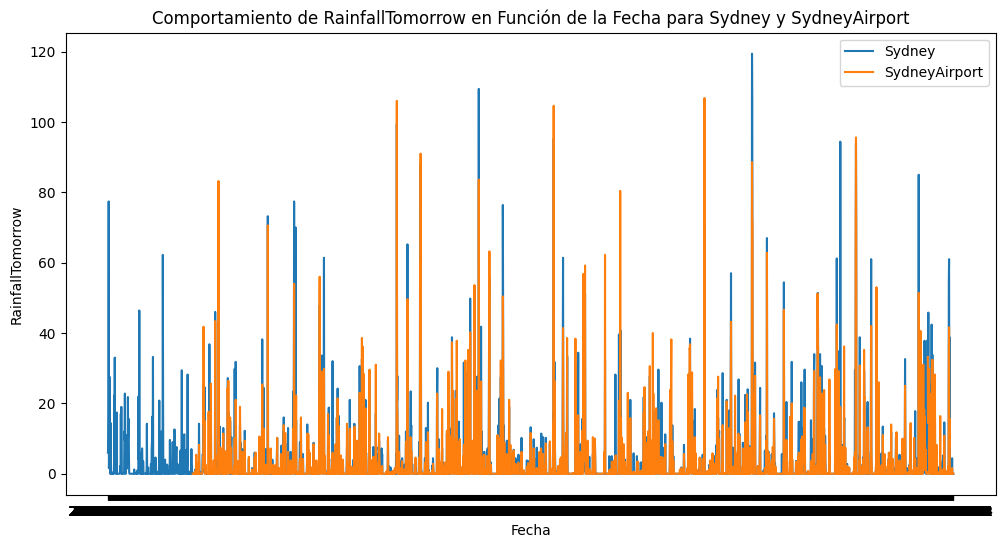

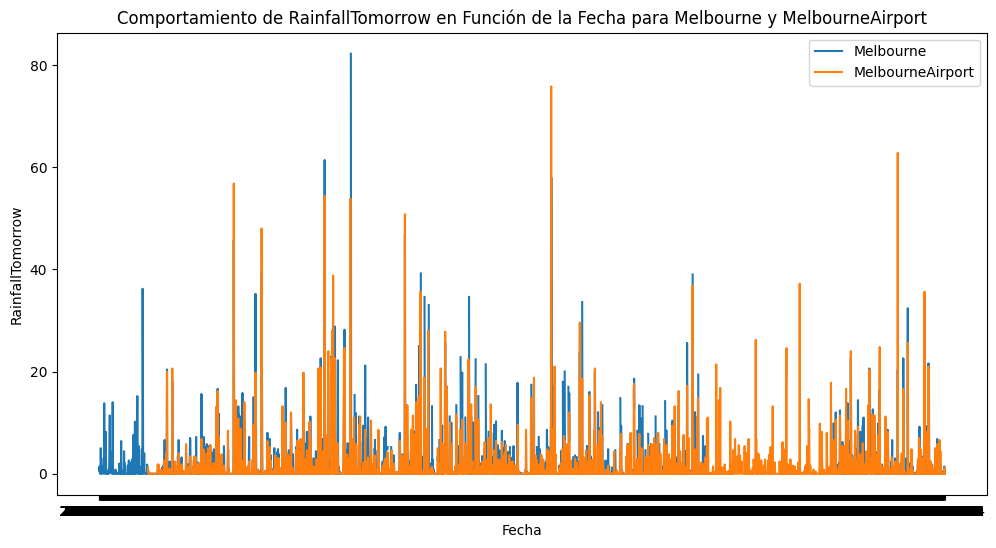

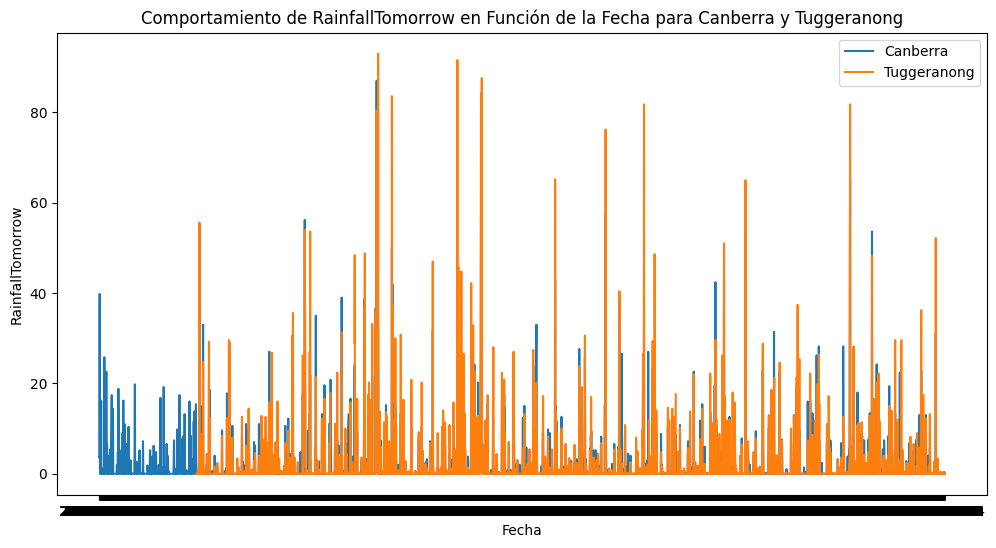

In [ ]:
# Se filtran datos para las ciudades de Sydney y SydneyAirport
sydney_data = df[df['Location'] == 'Sydney']
sydney_airport_data = df[df['Location'] == 'SydneyAirport']

# Visualización del comportamiento de la variable 'RainfallTomorrow' en función de la fecha para ambas ciudades
plt.figure(figsize=(12, 6))
plt.plot(sydney_data['Date'], sydney_data['RainfallTomorrow'], label='Sydney')
plt.plot(sydney_airport_data['Date'], sydney_airport_data['RainfallTomorrow'], label='SydneyAirport')
plt.xlabel('Fecha')
plt.ylabel('RainfallTomorrow')
plt.title('Comportamiento de RainfallTomorrow en Función de la Fecha para Sydney y SydneyAirport')
plt.legend()
plt.show()

Melbourne_data = df[df['Location'] == 'Melbourne']
Melbourne_airport_data = df[df['Location'] == 'MelbourneAirport']


plt.figure(figsize=(12, 6))
plt.plot(Melbourne_data['Date'], Melbourne_data['RainfallTomorrow'], label='Melbourne')
plt.plot(Melbourne_airport_data['Date'], Melbourne_airport_data['RainfallTomorrow'], label='MelbourneAirport')
plt.xlabel('Fecha')
plt.ylabel('RainfallTomorrow')
plt.title('Comportamiento de RainfallTomorrow en Función de la Fecha para Melbourne y MelbourneAirport')
plt.legend()
plt.show()

Canberra_data = df[df['Location'] == 'Canberra']
Tuggeranong_data = df[df['Location'] == 'Tuggeranong']


plt.figure(figsize=(12, 6))
plt.plot(Canberra_data['Date'], Canberra_data['RainfallTomorrow'], label='Canberra')
plt.plot(Tuggeranong_data['Date'], Tuggeranong_data['RainfallTomorrow'], label='Tuggeranong')
plt.xlabel('Fecha')
plt.ylabel('RainfallTomorrow')
plt.title('Comportamiento de RainfallTomorrow en Función de la Fecha para Canberra y Tuggeranong')
plt.legend()
plt.show()

Vemos que las ciudades tienen un comportamiento similar comparando la variable de interes. Por lo cual decidimos asignar los datos de una, cuando la otra contiene nulos.

In [ ]:
# Se puede obtener la información para Sydney desde Sidney Airport y viceversa
# Se puede obtener la información para Melbourne desde Melbourne Airport y viceversa
# Se puede obtener la información de Canberra desde Tuggeranong

# Para cada variable, reemplazamos los datos nulos de la locación con los existentes para misma fecha en la locación cercana
lista_variables = ['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed',\
                   'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm',\
                   'Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','RainToday',\
                   'RainTomorrow','RainfallTomorrow']

listas_reemplazo = [['Sydney','SydneyAirport'],['SydneyAirport','Sydney'],['Melbourne','MelbourneAirport'],['MelbourneAirport','Melbourne'],['Canberra','Tuggeranong']]

for variable in lista_variables:
  print('Actualizando ', variable)
  for pareja in listas_reemplazo:

    for index, row in df.iterrows():
        # Verifica si el valor de la variable es nulo y el valor de 'Location' es el del indice 0 de la tupla.
        if pd.isnull(row[variable]) and row['Location'] == pareja[0]:
            # Imprime o almacena el valor de la columna 'Date' correspondiente.
            date_value = row['Date']
            #print("Fecha con", variable, "nulo en ", pareja[0], {date_value})
            #print(row[variable])
            try:
              df.at[index, variable] = df.loc[(df['Date'] == date_value) & (df['Location'] == pareja[1]), variable].values[0]
              #print(df.at[index, variable])
            except IndexError:
              df.at[index, variable] = None


Actualizando  MinTemp
Actualizando  MaxTemp
Actualizando  Rainfall
Actualizando  Evaporation
Actualizando  Sunshine
Actualizando  WindGustDir
Actualizando  WindGustSpeed
Actualizando  WindDir9am
Actualizando  WindDir3pm
Actualizando  WindSpeed9am
Actualizando  WindSpeed3pm
Actualizando  Humidity9am
Actualizando  Humidity3pm
Actualizando  Pressure9am
Actualizando  Pressure3pm
Actualizando  Cloud9am
Actualizando  Cloud3pm
Actualizando  Temp9am
Actualizando  Temp3pm
Actualizando  RainToday
Actualizando  RainTomorrow
Actualizando  RainfallTomorrow


In [ ]:
## Quitamos Tuggeranong para dejar el dataframe solamente con las locaciones de interés
# Lista de ubicaciones de interés
ubicaciones_permitidas = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df.drop(['Unnamed: 0'], axis=1)

# Filtramos el DataFrame para quedarnos solo con las ubicaciones permitidas
df = df[df['Location'].isin(ubicaciones_permitidas)]

### Cantidad de valores faltantes de todas las columnas del dataset.

df.isna().sum()

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation         1706
Sunshine            1948
WindGustDir          422
WindGustSpeed        421
WindDir9am           304
WindDir3pm            27
WindSpeed9am          15
WindSpeed3pm           6
Humidity9am            1
Humidity3pm            2
Pressure9am            4
Pressure3pm            3
Cloud9am            1079
Cloud3pm            1264
Temp9am                1
Temp3pm                1
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [ ]:
# Pasamos las columnas RainTomorrow y RainToday de categórica a numérica
mapeo = {'Yes': 1, 'No': 0}

df['RainTomorrow'] = df['RainTomorrow'].map(mapeo)
df['RainToday'] = df['RainToday'].map(mapeo)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15986 entries, 30167 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15986 non-null  object 
 1   Location          15986 non-null  object 
 2   MinTemp           15986 non-null  float64
 3   MaxTemp           15986 non-null  float64
 4   Rainfall          15986 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       15564 non-null  object 
 8   WindGustSpeed     15565 non-null  float64
 9   WindDir9am        15682 non-null  object 
 10  WindDir3pm        15959 non-null  object 
 11  WindSpeed9am      15971 non-null  float64
 12  WindSpeed3pm      15980 non-null  float64
 13  Humidity9am       15985 non-null  float64
 14  Humidity3pm       15984 non-null  float64
 15  Pressure9am       15982 non-null  float64
 16  Pressure3pm       15983 non-null  fl

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


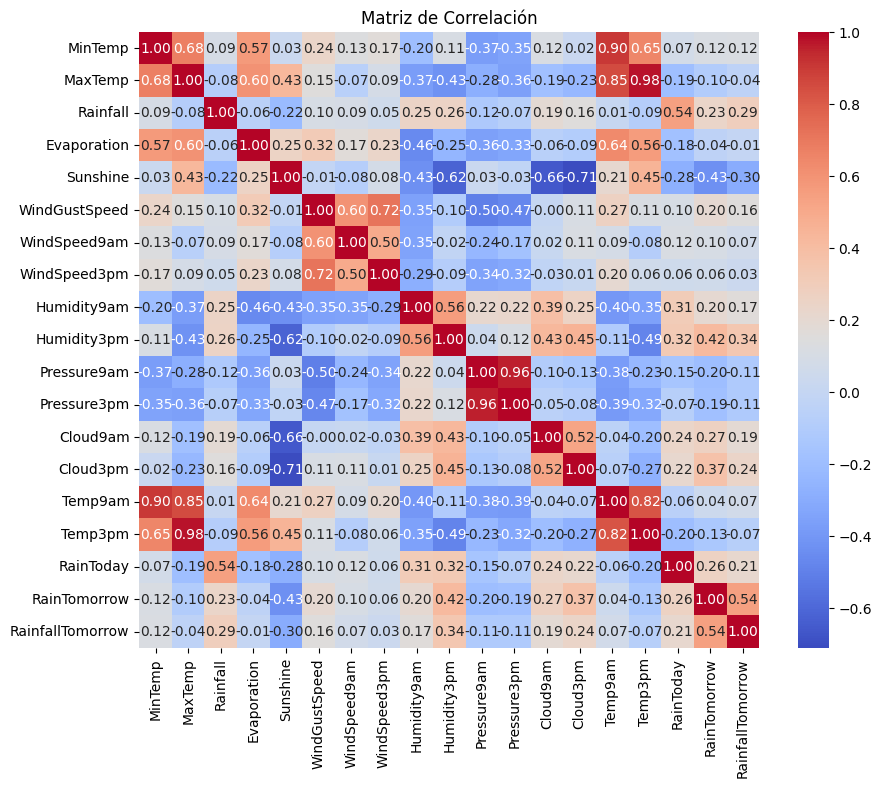

In [ ]:
# Imprimimos la matriz de correlación para ver qué columnas pueden ser representativas y cuales no.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


In [ ]:
correlacion_inversa = 0.69

# Asignamos el valor de uno al otro en casos que uno de los dos tenga datos
df['Cloud3pm'].fillna(df['Cloud9am'], inplace=True)
df['Cloud9am'].fillna(df['Cloud3pm'], inplace=True)

# Asignamos la inversa de Sunshine a los casos de que ni 9am ni 3pm tienen datos
df['Cloud3pm'].fillna(1 - correlacion_inversa * df['Sunshine'], inplace=True)
df['Cloud9am'].fillna(1 - correlacion_inversa * df['Sunshine'], inplace=True)

# Completamos con la inversa del promedio de 3pm y 9am cuando ambos tienen datos
df['Sunshine'].fillna(1 - correlacion_inversa * ((df['Cloud3pm'] + df['Cloud9am'])/2), inplace=True)





The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


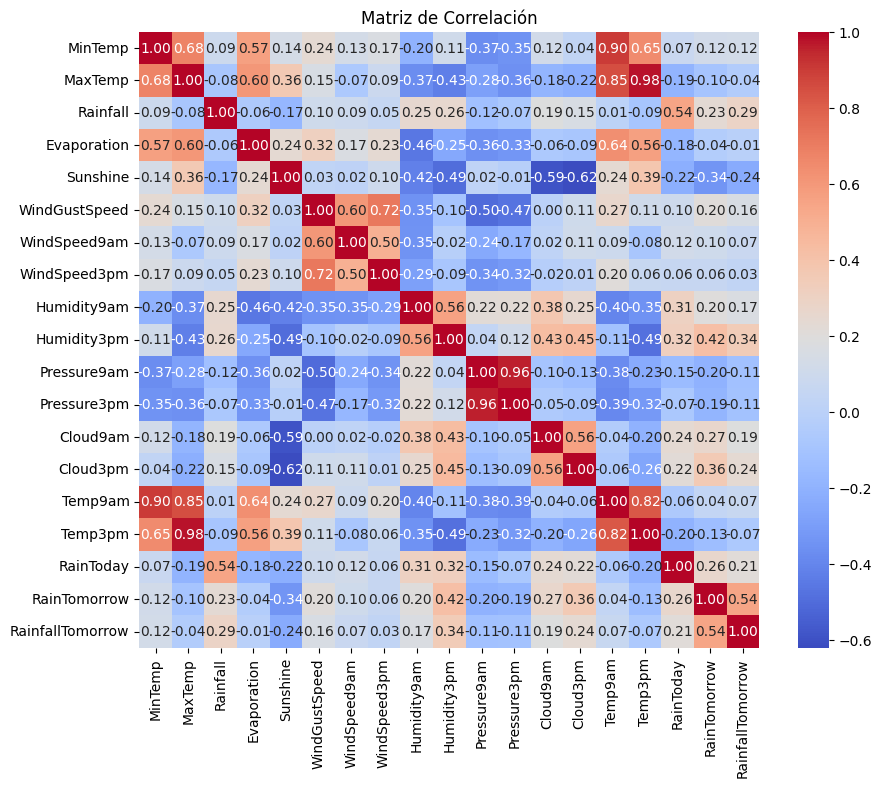

In [ ]:
# Imprimimos la matriz de correlación para ver qué columnas pueden ser representativas y cuales no.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
#Eliminamos temperaturas de 9 am y 3 pm, porque tienen una fuerte correlacion con max y min temp
df = df.drop(['Temp9am', 'Temp3pm'], axis = 1)

In [ ]:
### Nuevamente verificamos los valores faltantes de todas las columnas del dataset.
df.isna().sum()

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation         1706
Sunshine             769
WindGustDir          422
WindGustSpeed        421
WindDir9am           304
WindDir3pm            27
WindSpeed9am          15
WindSpeed3pm           6
Humidity9am            1
Humidity3pm            2
Pressure9am            4
Pressure3pm            3
Cloud9am             769
Cloud3pm             769
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [ ]:
#Eliminamos la columna Evaporation, ya que practicamente no tiene correlacion con las variables de interes y contiene muchos nulos
df = df.drop(['Evaporation'], axis=1)
#Eliminamos WinDir 9 am y 3pm, ya que nos quedamos con Windgustdir , si no deberiamos hacer encoder de todas.
df = df.drop(['WindDir9am','WindDir3pm'], axis=1)

In [ ]:
### Nuevamente verificamos los valores faltantes de todas las columnas del dataset.
df.isna().sum()

Date                  0
Location              0
MinTemp               0
MaxTemp               0
Rainfall              0
Sunshine            769
WindGustDir         422
WindGustSpeed       421
WindSpeed9am         15
WindSpeed3pm          6
Humidity9am           1
Humidity3pm           2
Pressure9am           4
Pressure3pm           3
Cloud9am            769
Cloud3pm            769
RainToday             0
RainTomorrow          0
RainfallTomorrow      0
dtype: int64

In [ ]:
# Lista de columnas en las que vamos a eliminar los valores nulos ya que 769 es menos del 5% de 15986.
columnas_a_eliminar_nulos = ['WindGustDir', 'Sunshine', 'Cloud9am','Cloud3pm','Humidity9am',\
                             'Humidity3pm','Pressure9am','Pressure3pm','WindGustSpeed','WindSpeed9am']

# Eliminamos las filas con valores nulos en las columnas especificadas.
df = df.dropna(subset=columnas_a_eliminar_nulos)
df.isna().sum()


Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

In [ ]:
# Agrupanos cada 4 direcciones de vientos en una para tener menos variables y con frecuencia más alta
norte = ['N', 'NNE', 'NE','NNW' ]
este = ['E', 'ESE', 'SE','ENE' ]
sur = ['S', 'SSW', 'SW', 'SSE']
oeste = ['W', 'WNW', 'NW','WSW' ]

# Generamos las nuevas columnas numéricas
def one_hot_encoding(direction):
    if direction in norte:
        return 'N'
    elif direction in este:
        return 'E'
    elif direction in sur:
        return 'S'
    elif direction in oeste:
        return 'W'
    else:
        return 'Other'


df['WindGustDir_Encoded'] = df['WindGustDir'].apply(one_hot_encoding)
df = pd.get_dummies(df, columns=['WindGustDir_Encoded'], prefix='WindGustDir')
df = df.drop(['WindGustDir'], axis = 1)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


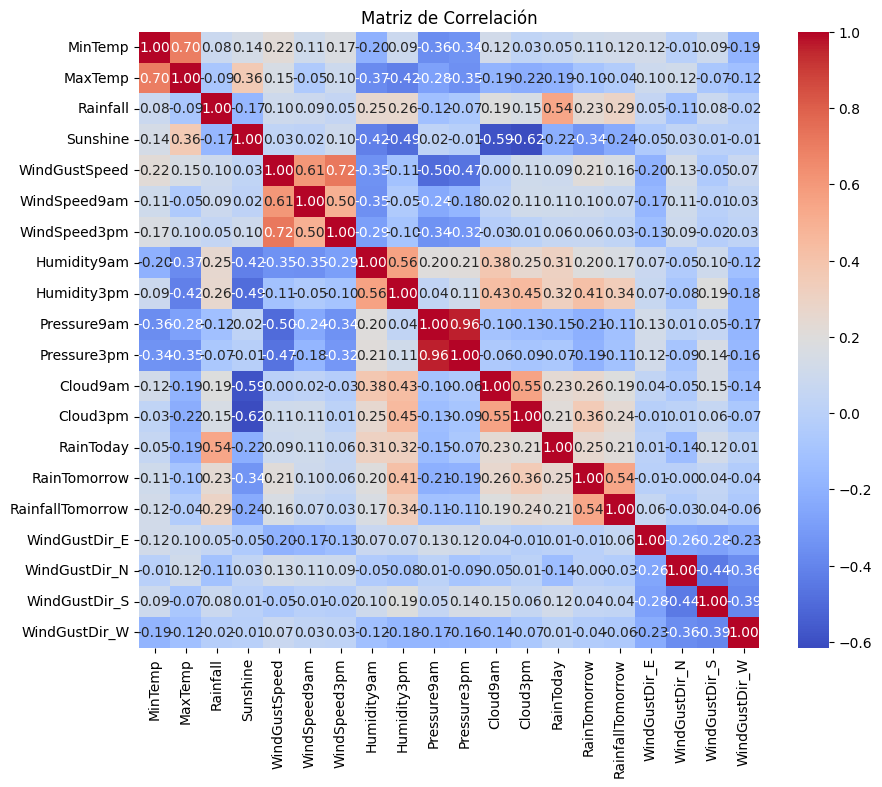

In [ ]:
# Imprimimos la matriz de correlación para ver qué columnas pueden ser representativas y cuales no.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

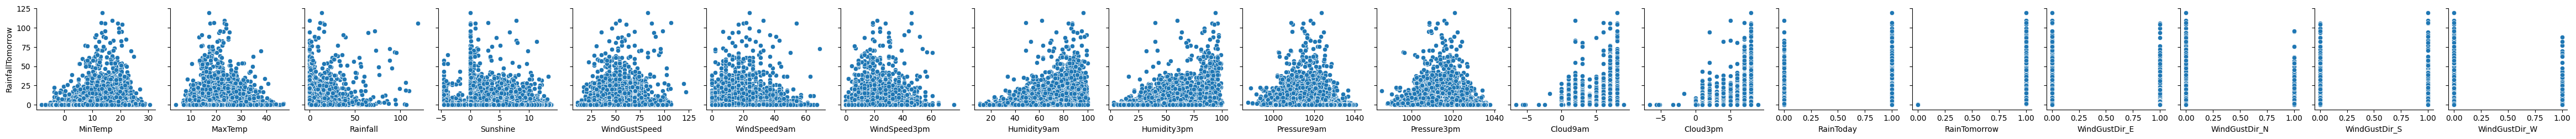

In [ ]:
#Mostramos la distribución para ver si hay linealidad
columnas = [col for col in df.columns if ((col != 'RainfallTomorrow') & (col != 'Location') & (col != 'Date'))]

sns.pairplot(df, x_vars=columnas, y_vars='RainfallTomorrow')
plt.show()

# **3.	Implementar la solución del problema de regresión con regresión lineal múltiple. .**

In [ ]:
# Quitamos las columnas que no nos interesarán y las que pueden generar fugas de datos.
X_regresion = df.drop(['Date','Location','RainTomorrow','RainfallTomorrow'], axis=1)
y_regresion = df['RainfallTomorrow']

# Separamos en train y test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_regresion, y_regresion, test_size=0.2, random_state=42)



# Se entrena el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_r, y_train_r)

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test_r)

# Métricas de evaluación
mse = mean_squared_error(y_test_r, y_pred)
r2 = r2_score(y_test_r, y_pred)
mse_r = round(mse, 3)
r2_r = round(r2, 3)

print(f'Mean Squared Error (MSE): {mse_r}')
print(f'R-squared (R^2): {r2_r}')

Mean Squared Error (MSE): 42.691
R-squared (R^2): 0.247


Validación cruzada

In [ ]:


# Definimos las métricas que queremos calcular
scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

# Realizamos validación cruzada en el conjunto de entrenamiento
cv_results = cross_validate(model, X_train_r, y_train_r, cv=5, scoring=scoring)

# Accedemos a las métricas individuales para cada pliegue
mse_scores = cv_results['test_mse']
r2_scores = cv_results['test_r2']

# Mostramos las métricas para cada pliegue
for i, (mse, r2) in enumerate(zip(mse_scores, r2_scores), 1):
    print(f'Fold {i}: Mean Squared Error (MSE): {round(mse, 3)}, R-squared (R^2): {round(r2, 3)}')



Fold 1: Mean Squared Error (MSE): 47.241, R-squared (R^2): 0.244
Fold 2: Mean Squared Error (MSE): 30.356, R-squared (R^2): 0.209
Fold 3: Mean Squared Error (MSE): 47.259, R-squared (R^2): 0.19
Fold 4: Mean Squared Error (MSE): 47.928, R-squared (R^2): 0.218
Fold 5: Mean Squared Error (MSE): 41.173, R-squared (R^2): 0.193


Como achicamos el conjunto de entrenamiento, vemos que las métricas empeoran en las pruebas, entendemos que no esta sobreajustando nuestro modelo y decidimos continuar con la división anterior ya que tenemos suficientes datos de test.

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate

# Creamos el modelo de regresión lineal
model = LinearRegression()

# Definimos las métricas que queremos calcular
scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

# Realizamos validación cruzada
cv_results = cross_validate(model, X_train_r, y_train_r, cv=5, scoring=scoring)

# Calculamos las métricas promedio
mse_mean = np.mean(cv_results['test_mse'])
r2_mean = np.mean(cv_results['test_r2'])

print(f'Mean Squared Error (MSE) promedio en validación cruzada: {round(mse_mean, 3)}')
print(f'R-squared (R^2) promedio en validación cruzada: {round(r2_mean, 3)}')

Mean Squared Error (MSE) promedio en validación cruzada: 42.792
R-squared (R^2) promedio en validación cruzada: 0.211


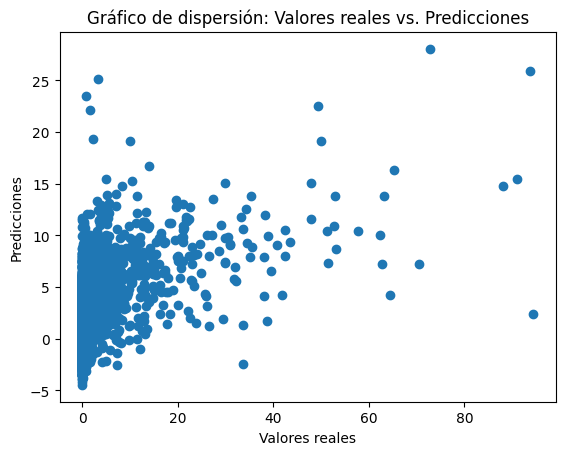

In [ ]:
#Graficamos la distribución de los valores reales contra las predicciones.
plt.scatter(y_test_r, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de dispersión: Valores reales vs. Predicciones")
plt.show()

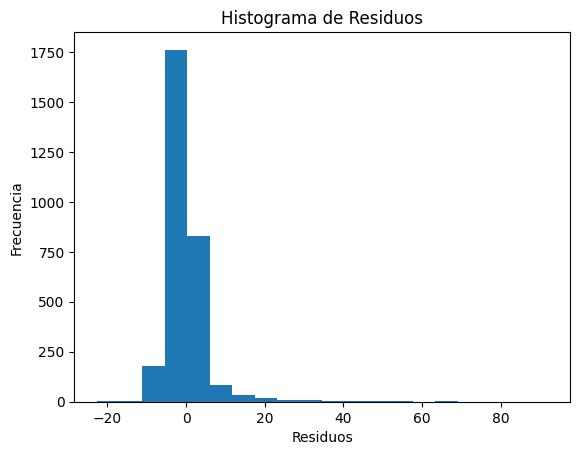

In [ ]:
#Hacemos un histograma de la distribución de los residuos
residuos = y_test_r - y_pred
plt.hist(residuos, bins=20)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de Residuos")
plt.show()

# Implementación del modelo de regresión lineal utilizando el algoritmo de gradiente descendiente

In [ ]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_r)
X_test_scaled = scaler.transform(X_test_r)

# Se inicializan los pesos
weights = np.zeros(X_train_scaled.shape[1])

# Se definen los hiperparámetros
learning_rate = 0.01
epochs = 1000

# Entrenamiento del modelo con gradiente descendente
for epoch in range(epochs):
    predictions = np.dot(X_train_scaled, weights)
    error = y_train_r - predictions
    gradient = -2 * np.dot(X_train_scaled.T, error) / len(X_train_scaled)
    weights -= learning_rate * gradient

# Se aplica el modelo a los datos de prueba escalados
predictions_test = np.dot(X_test_scaled, weights)

# Cálculo de métricas de evaluación
mse = mean_squared_error(y_test_r, predictions_test)
r2 = r2_score(y_test_r, predictions_test)
mse_r = round(mse, 3)
r2_r = round(r2, 3)

print(f"Error cuadrático medio (MSE): {mse_r}")
print(f"Coeficiente de determinación (R^2): {r2_r}")

Error cuadrático medio (MSE): 47.983
Coeficiente de determinación (R^2): 0.154


In [ ]:
# Aplicamos regularización Lasso

# Creamos un modelo de regresión Lasso.
alpha = 0.01
lasso_model = Lasso(alpha=alpha)

# Entrenamos el modelo Lasso con los datos de entrenamiento.
lasso_model.fit(X_train_scaled, y_train_r)

# Realizamos predicciones con el modelo Lasso.
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculamos las métricas de evaluación con Lasso.
mse_lasso = mean_squared_error(y_test_r, y_pred_lasso)
r2_lasso = r2_score(y_test_r, y_pred_lasso)
mse_lasso_r = round(mse_lasso, 3)
r2_lasso_r = round(r2_lasso, 3)
# Obtenemos los coeficientes del modelo Lasso.
coeficientes_lasso = lasso_model.coef_

print(f"Error cuadrático medio (Lasso): {mse_lasso_r}")
print(f"Coeficiente de determinación (R2) (Lasso): {r2_lasso_r}")

Error cuadrático medio (Lasso): 42.684
Coeficiente de determinación (R2) (Lasso): 0.247


In [ ]:
# Aplicamos regularización Ridge

# Valores de alpha a probar
alphas = [0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 100.0]

# Creamos un modelo de regresión Ridge
modelo = Ridge()

# Definimos la cuadrícula de búsqueda
param_grid = {'alpha': alphas}

# Realizamos la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_r)

# Mejor valor de alpha encontrado
mejor_alpha = grid_search.best_params_['alpha']

# Creamos un modelo Ridge con el mejor alpha
modelo_ridge = Ridge(alpha=mejor_alpha)

# Ajustamos el modelo Ridge a los datos de entrenamiento escalados
modelo_ridge.fit(X_train_scaled, y_train_r)

# Realizamos predicciones en los datos de prueba escalados
y_pred_ridge = modelo_ridge.predict(X_test_scaled)

# Evaluamos el rendimiento del modelo Ridge
mse_ridge = mean_squared_error(y_test_r, y_pred_ridge)
r2_ridge = r2_score(y_test_r, y_pred_ridge)
mse_ridge_r = round(mse_ridge, 3)
r2_ridge_r = round(r2_ridge, 3)

print(f"Error cuadrático medio (Ridge): {mse_ridge_r}")
print(f"Coeficiente de determinación (R2) (Ridge): {r2_ridge_r}")

Error cuadrático medio (Ridge): 42.69
Coeficiente de determinación (R2) (Ridge): 0.247


In [ ]:
# Aplicamos regularización ElasticNet

# Creamos un modelo de regresión lineal con regularización Elastic Net
modelo_elastic_net = ElasticNet(alpha=10, l1_ratio=0.1)

# Ajustamos el modelo a los datos de entrenamiento
modelo_elastic_net.fit(X_train_r, y_train_r)

# Realizamos predicciones en los datos de prueba
y_pred_elastic_net = modelo_elastic_net.predict(X_test_r)

# Evaluamos el rendimiento del modelo Elastic Net
mse_elastic_net = mean_squared_error(y_test_r, y_pred_elastic_net)
r2_elastic_net = r2_score(y_test_r, y_pred_elastic_net)
mse_elastic_net_r = round(mse_elastic_net,3)
r2_elastic_net_r = round(r2_elastic_net,3)
print(f"Error cuadrático medio (Elastic Net): {mse_elastic_net_r}")
print(f"Coeficiente de determinación (R2) (Elastic Net): {r2_elastic_net_r}")

Error cuadrático medio (Elastic Net): 43.933
Coeficiente de determinación (R2) (Elastic Net): 0.225


Nos quedamos con el primer modelo porque la regularizaciones no mejoran las métricas.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


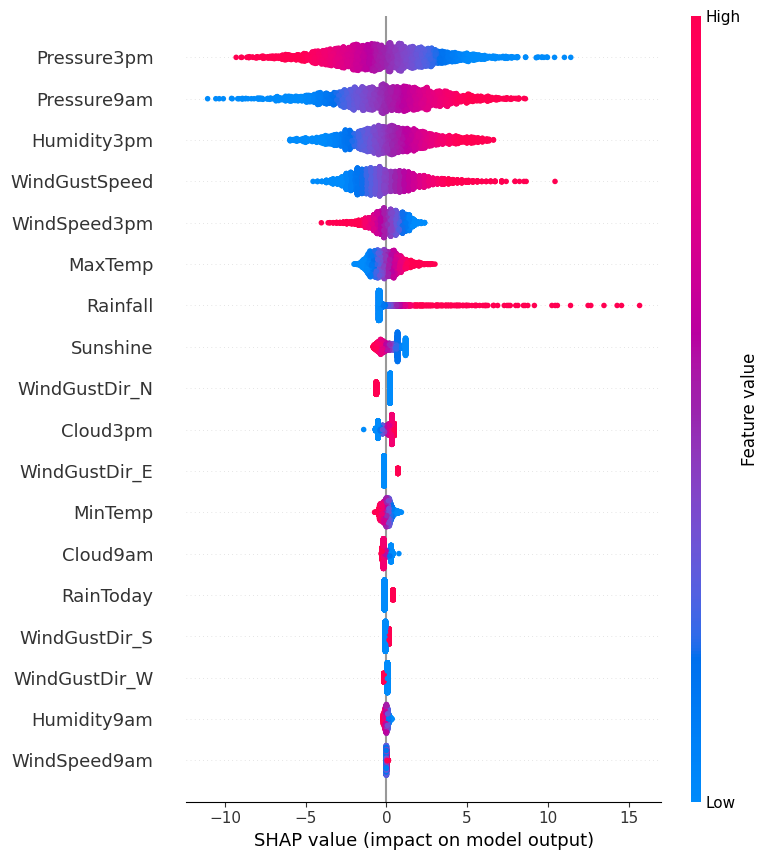

In [ ]:
# SHAP

# Creamos un objeto explainer SHAP específico para modelos lineales
explainer = shap.LinearExplainer(model, X_train_r, feature_perturbation="interventional")

# Calculamos los valores SHAP para el conjunto de prueba
shap_values = explainer.shap_values(X_test_r)

# Visualizamos el resumen de SHAP con nombres de características
shap.summary_plot(shap_values, X_test_r, feature_names=X_regresion.columns.tolist())

En este gráfico podemos ver que las variables mas ponderadas de la regresión son las de presion y humedad, que van a contribuir para definir tanto los valores altos de lluvia para el dia posterior como los bajos. Por otro lado vemos que a la variable 'Rainfall' la utiliza de una forma que va a elevar el numero de la predicción. El resto de las variables prácticamente no las utiliza.

# **4.	Implementar la solución del problema de clasificación con regresión logística.**
 ●	Obtener las métricas adecuadas (entre Accuracy, precision, recall, F1 Score, ROC-AUC, entre otras).

In [ ]:
# Generamos los boxplot para visualizar la relación entre las características (variables independientes) y la variable objetivo (target)
def boxplots(X, y, z):
    data = pd.concat([pd.DataFrame(X, columns=z), pd.DataFrame(y, columns=['RainTomorrow'])], axis=1)

    num_features = len(z)

    # Número de filas y columnas necesarias para la disposición de subgráficos
    num_rows = (num_features - 1) // 3 + 1
    num_cols = min(num_features, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Se definen los colores
    colors = ['red', 'green']

    # Se recorre cada feature para generar su diagrama de caja respecto de la salida
    for i, feature in enumerate(data.columns[:-1]):  # Excluimos la última columna que es la variable de salida
        row = i // num_cols
        col = i % num_cols
        sns.boxplot(x='RainTomorrow', y=feature, data=data, ax=axes[row, col,], palette=colors)
        axes[row, col].set_title(f'Diagrama de caja de {feature}')
        axes[row, col].set_xlabel('RainTomorrow')
        axes[row, col].set_ylabel(feature)

    # Elimina subplots vacíos si es necesario
    if num_features % num_cols != 0:
        for i in range(num_features % num_cols, num_cols):
            fig.delaxes(axes[num_rows - 1, i])

    plt.show()

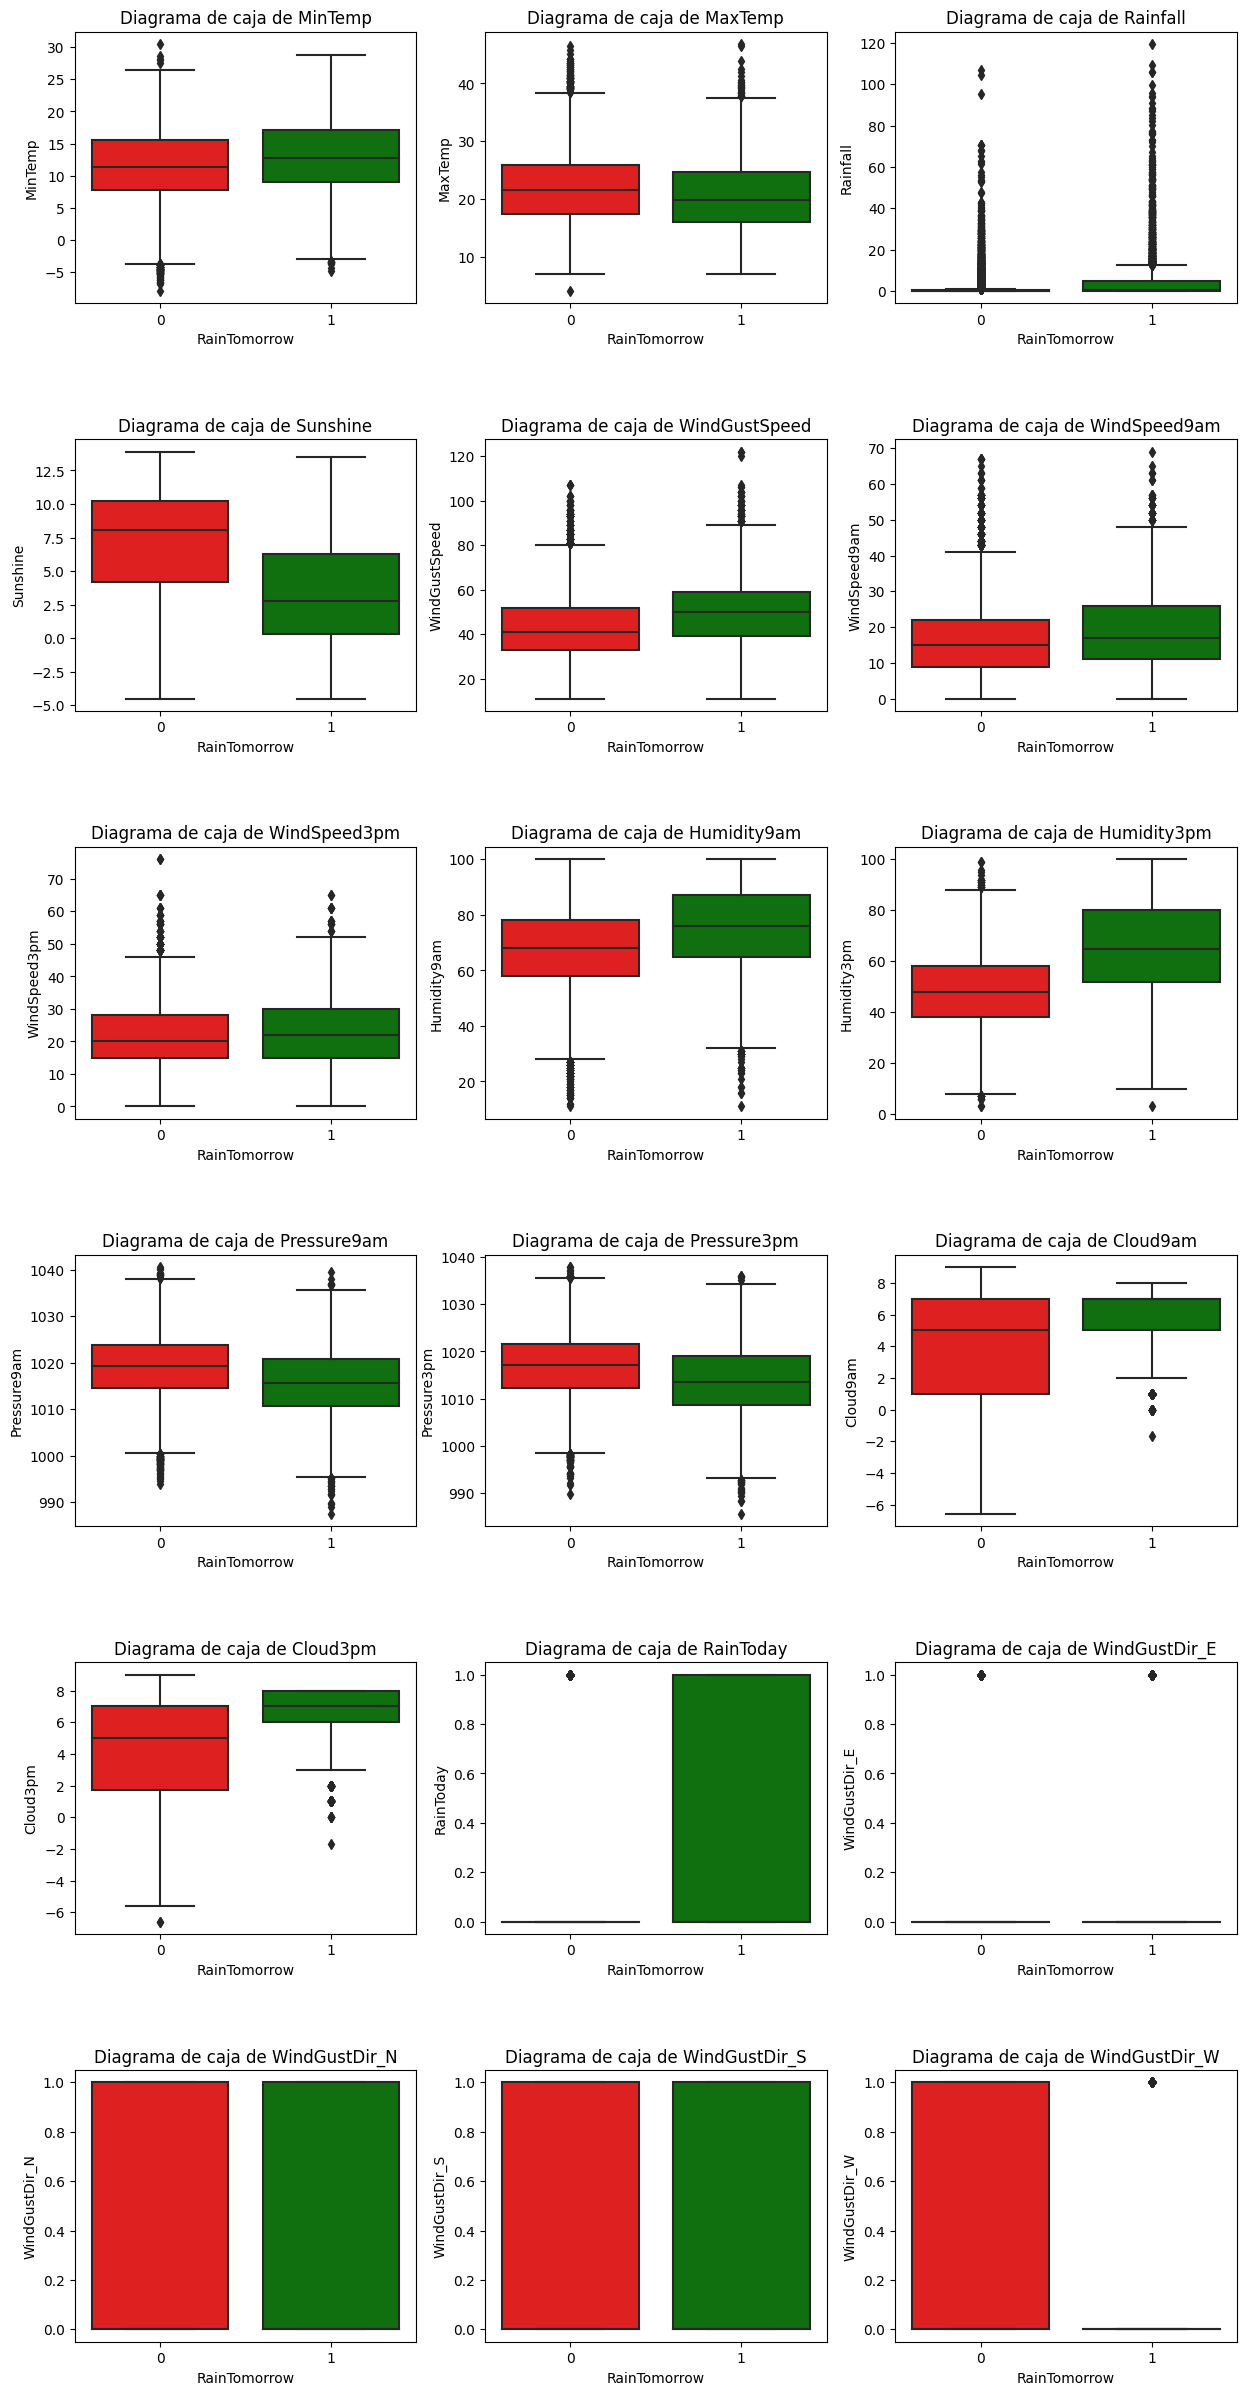

In [ ]:
#Dividimos las variables en entrenamiento y test para entrenar el modelo luego, pero generamos los gráficos con todos los datos
X_clasificacion = df.drop(['Date','Location','RainTomorrow','RainfallTomorrow'], axis=1)
y_clasificacion = df['RainTomorrow']


X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clasificacion, y_clasificacion, test_size=0.2, random_state=42)
boxplots(X_clasificacion, y_clasificacion, X_clasificacion.columns)




In [ ]:
#Este código lo corrimos para exportar el csv para la app

#train_data = pd.DataFrame(X_train_c, columns=X_train_c.columns)
#train_data['target'] = y_train_c

# Guarda el DataFrame en un archivo CSV
#train_data.to_csv('train_data.csv', index=False)

In [ ]:
#Modelo de clasificación logística y sus metricas

# Escalado de características
scaler = StandardScaler()
X_train_scaled_c = scaler.fit_transform(X_train_c)
X_test_scaled_c = scaler.transform(X_test_c)

# Inicializa y entrena el modelo de regresión logística
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled_c, y_train_c)

# Se realizan predicciones en los datos de prueba escalados
y_pred = logistic_model.predict(X_test_scaled_c)

# Se imprimen los resultados
print("Resultados con regresión logística\n")
print(classification_report(y_test_c, y_pred))
print(confusion_matrix(y_test_c, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2238
           1       0.73      0.52      0.61       720

    accuracy                           0.84      2958
   macro avg       0.80      0.73      0.75      2958
weighted avg       0.83      0.84      0.83      2958

[[2104  134]
 [ 349  371]]


Validación cruzada

In [ ]:


# Realizamos validación cruzada y obtener predicciones para cada pliegue
y_pred_cv = cross_val_predict(logistic_model, X_train_scaled_c, y_train_c, cv=5)


print("Resultados de la validación cruzada con regresión logística\n")
print(classification_report(y_train_c, y_pred_cv))

Resultados de la validación cruzada con regresión logística

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      9018
           1       0.70      0.48      0.57      2814

    accuracy                           0.83     11832
   macro avg       0.78      0.71      0.73     11832
weighted avg       0.82      0.83      0.82     11832



Vemos que tanto el modelo, como la validación cruzada tienen una tendencia a sobreajustar la predicción negativa, entendemos que es porque es la clase mayoritaria. Por este motivo, procedemos a balancear las clases.

In [ ]:
#Aplicamos el balanceo

under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train_c, y_train_c)



In [ ]:
# Normalizamos de características
scaler = StandardScaler()

X_resampled_normalized = scaler.fit_transform(X_resampled)
X_test_normalized = scaler.transform(X_test_c)

# Creamos y ajustamos el modelo de regresión logística
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_resampled_normalized, y_resampled)

# Predicciones y evaluación del modelo
y_pred = logistic_model.predict(X_test_normalized)

print("Resultados con regresión logística\n")
print(classification_report(y_test_c, y_pred))
print(confusion_matrix(y_test_c, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2238
           1       0.51      0.77      0.61       720

    accuracy                           0.77      2958
   macro avg       0.71      0.77      0.72      2958
weighted avg       0.81      0.77      0.78      2958

[[1710  528]
 [ 166  554]]


Nos quedamos con el modelo balanceado, porque si bien bajan las metricas de la predicción negativa, valoramos que suban las positivas, ya que en este caso, preferimos que tenga una mayor exactitud en la predicción de que va a llover al día siguiente.

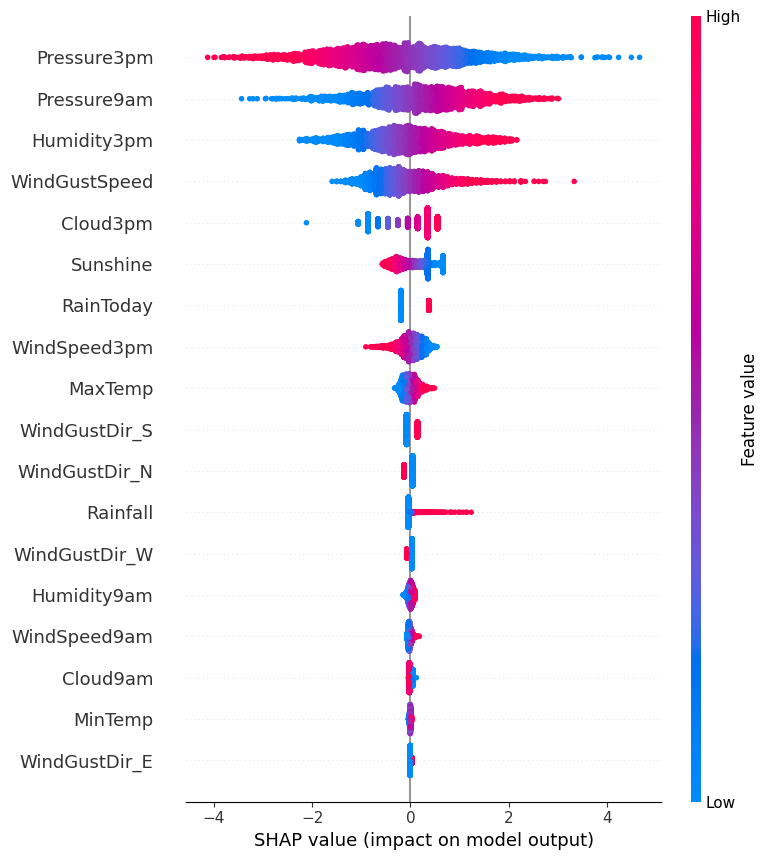

In [ ]:
X_resampled_df = pd.DataFrame(X_resampled_normalized, columns=X_resampled.columns)
X_test_df = pd.DataFrame(X_test_normalized, columns=X_test_c.columns)

# Inicializamos el explainer SHAP con el modelo entrenado y los datos de entrenamiento
explainer = shap.Explainer(logistic_model, X_resampled_df)

# Calculamos los valores SHAP para las muestras de prueba
shap_values = explainer.shap_values(X_test_df)

# Resumen de los valores SHAP
shap.summary_plot(shap_values, X_test_df)

Parecida a la utilización de la variables en la regresión, en este caso podemos ver que la variable 'Pressure3pm' mientras mas elevado es el dato va a colaborar a que la prediccion sea negativa, al contrario de presion9am , humedad, viento y cantidad de lluvia del día, que parece tener una correlación positiva con la predicción.

In [ ]:

# Se obtienen las probabilidades de predicción del modelo
y_probs = logistic_model.predict_proba(X_test_normalized)[:, 1]

# Cálculo de la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_c, y_probs)
roc_auc = auc(fpr, tpr)

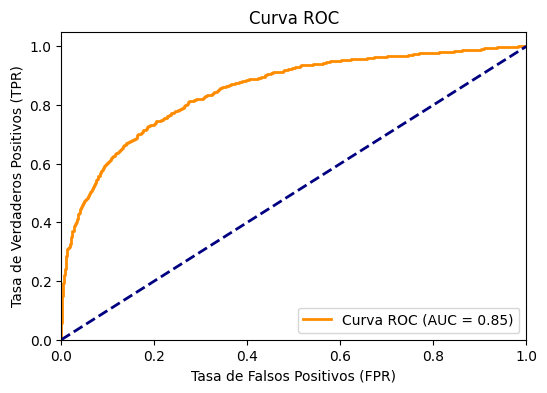

In [ ]:
# Grafico de la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# **5.Implementar un modelo base para clasificación y uno para regresión.	.**

In [ ]:
# Modelo base de clasificación utilizando la clase mayoritaria

# Creación del modelo base
model_baseline = DummyClassifier(strategy='most_frequent')

# Entrenamiento del modelo base
model_baseline.fit(X_train_c, y_train_c)

# Evaluación del modelo base
y_pred_baseline = model_baseline.predict(X_test_c)
accuracy_baseline = accuracy_score(y_test_c, y_pred_baseline)

print(f"Exactitud (Accuracy) del modelo base de clasificación: {accuracy_baseline}")



Exactitud (Accuracy) del modelo base de clasificación: 0.7565922920892495


In [ ]:
#Modelo base para regresión

mean_target = y_train_r.mean()  # Calculamos la media de la variable objetivo en el conjunto de entrenamiento.
predictions_baseline = [mean_target] * len(X_test_r)  # Repetimos la media para todas las muestras en el conjunto de prueba

# Evaluación del modelo base de regresión
mse_baseline = mean_squared_error(y_test_r, predictions_baseline)
r2_baseline = r2_score(y_test_r, predictions_baseline)

print(f"Error cuadrático medio (MSE) del modelo base de regresión: {mse_baseline}")
print(f"Coeficiente de determinación (R^2) del modelo base de regresión: {r2_baseline}")



Error cuadrático medio (MSE) del modelo base de regresión: 56.70624948998624
Coeficiente de determinación (R^2) del modelo base de regresión: -0.00016401941909571782


# **6.Implementar las soluciones con una red neuronal.**
*Obtener las métricas adecuadas.*

In [ ]:
# Función que define el espacio de búsqueda de hiperparámetros para el modelo de regresión de redes neuronales.
def objective(trial):
    n_neurons_layer1 = trial.suggest_int('n_neurons_layer1', 64, 128)
    n_neurons_layer2 = trial.suggest_int('n_neurons_layer2', 16, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    model = MLPRegressor(
        hidden_layer_sizes=(n_neurons_layer1, n_neurons_layer2),
        activation='relu',
        solver='adam',
        learning_rate_init=learning_rate,
        max_iter=20,
        random_state=42
    )

    model.fit(X_train_r, y_train_r)

    y_pred = model.predict(X_test_r)
    r2 = r2_score(y_test_r, y_pred)

    return r2  # Negamos el R cuadrado porque Optuna busca minimizar, y queremos maximizar el R cuadrado

# creamos un estudio de optimización con Optuna para encontrar los mejores hiperparámetros que maximicen la función objetivo
study = optuna.create_study(direction='maximize')  # Maximizamos el R cuadrado
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)

[I 2023-12-07 12:58:50,055] A new study created in memory with name: no-name-907e2d3d-6f85-48d4-8594-554133ab2663
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
[I 2023-12-07 12:58:51,849] Trial 0 finished with value: 0.22563791162431246 and parameters: {'n_neurons_layer1': 105, 'n_neurons_layer2': 17, 'learning_rate': 0.000977333869530948}. Best is trial 0 with value: 0.22563791162431246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
[I 2023-12-07 12:58:53,491] Trial 1 finished with value: 0.22595535504015063 and

Mejores parámetros encontrados: {'n_neurons_layer1': 109, 'n_neurons_layer2': 16, 'learning_rate': 0.00831186612748527}


In [ ]:
# Traemos los mejores parámetros de la optimización
best_params = study.best_params

# Creamos un nuevo modelo MLPRegressor con los mejores parámetros
best_model = MLPRegressor(
    hidden_layer_sizes=(best_params['n_neurons_layer1'], best_params['n_neurons_layer2']),
    activation='relu',
    solver='adam',
    learning_rate_init=best_params['learning_rate'],
    max_iter=100,  # Puedes ajustar este valor según sea necesario
    random_state=42
)

# Ajustamos el modelo a los datos de entrenamiento
best_model.fit(X_train_r, y_train_r)

# Predicciones en los datos de prueba
y_pred = best_model.predict(X_test_r)

# Cálculo del coeficiente de determinación (R cuadrado)
r2 = r2_score(y_test_r, y_pred)

# Calculo del error cuadrático medio (MSE)
mse = mean_squared_error(y_test_r, y_pred)

# Redondeo de las métricas a tres dígitos después de la coma decimal
r2_rounded = round(r2, 3)
mse_rounded = round(mse, 3)

# Mostramos las métricas
print(f"Coeficiente de Determinación (R cuadrado): {r2_rounded}")
print(f"Error Cuadrático Medio (MSE): {mse_rounded}")

Coeficiente de Determinación (R cuadrado): 0.324
Error Cuadrático Medio (MSE): 38.313


Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


PermutationExplainer explainer: 2959it [02:18, 19.87it/s]                          


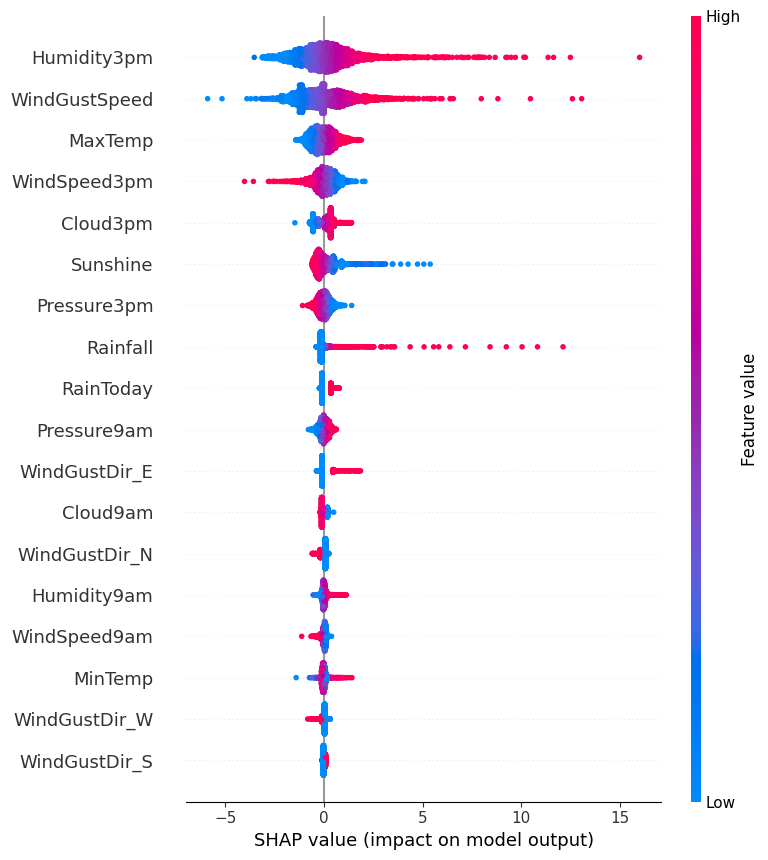

In [ ]:
# Función wrapper para el modelo que acepte un solo conjunto de datos como entrada
def model_wrapper(input_data):
    return best_model.predict(input_data)

# Inicializamos el explainer SHAP con la función wrapper y los datos de entrenamiento
explainer = shap.Explainer(model_wrapper, X_train_r)

# Calculamos los valores SHAP para las muestras de prueba
shap_values = explainer.shap_values(X_test_r)

# Resumen de los valores SHAP
shap.summary_plot(shap_values, X_test_r, feature_names=X_test_r.columns)

Si bien no podemos asegurar nada, porque no sabemos como se utilizan las variables en la capa oculta, vemos una tendencia de utilizar las variables que estan fuertemente correlacionadas con la de interes, al igual que los modelos anteriores.

Optimización de parametros para red neuronal de clasificación

In [ ]:
# Función que define el espacio de búsqueda de hiperparámetros para el modelo de clasificación de redes neuronales.
def objective(trial):
    n_neurons_layer1 = trial.suggest_int('n_neurons_layer1', 64, 128)
    n_neurons_layer2 = trial.suggest_int('n_neurons_layer2', 16, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    model = MLPClassifier(
        hidden_layer_sizes=(n_neurons_layer1, n_neurons_layer2),
        activation='relu',
        solver='adam',
        learning_rate_init=learning_rate,
        max_iter=20,
        random_state=42
    )

    model.fit(X_train_scaled_c, y_train_c)

    y_pred = model.predict(X_test_scaled_c)
    accuracy = accuracy_score(y_test_c, y_pred)

    return accuracy

# Creamos un estudio de optimización con Optuna para encontrar los mejores hiperparámetros que maximicen la función objetivo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params_c = study.best_params
print("Mejores parámetros encontrados:", best_params)

[I 2023-12-07 13:03:10,082] A new study created in memory with name: no-name-8c6b0826-39be-4518-a3f5-8363d8d3c7c9
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
[I 2023-12-07 13:03:11,869] Trial 0 finished with value: 0.830290736984449 and parameters: {'n_neurons_layer1': 69, 'n_neurons_layer2': 20, 'learning_rate': 0.018174797531922027}. Best is trial 0 with value: 0.830290736984449.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
[I 2023-12-07 13:03:13,801] Trial 1 finished with value: 0.8387423935091278 and param

Mejores parámetros encontrados: {'n_neurons_layer1': 109, 'n_neurons_layer2': 16, 'learning_rate': 0.00831186612748527}


In [ ]:

# Metemos los mejores parámetros en una variable
best_params_c = study.best_params

# Creamos el modelo MLPClassifier de scikit-learn
best_model = MLPClassifier(
    hidden_layer_sizes=(best_params_c['n_neurons_layer1'], best_params_c['n_neurons_layer2']),
    activation='relu',
    solver='adam',
    learning_rate_init=best_params_c['learning_rate'],
    max_iter=100,
    random_state=42
)

# Entrenamos el modelo con los datos de entrenamiento
best_model.fit(X_train_scaled_c, y_train_c)

# Hacemos predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled_c)

# Calculamos la precisión del modelo
accuracy = accuracy_score(y_test_c, y_pred)
accuracy_r = round(accuracy,3)
print(f"Accuracy: {accuracy_r}")


Accuracy: 0.845


Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


In [ ]:
#Exportamos el modelo en .pkl
#joblib.dump(best_model, 'modelo.pkl')
#loaded_model = joblib.load('modelo.pkl')

# **Conclusion final**

Una vez que cumplimos con todos los procesos, podemos afirmar con certeza que, tal cual se nos explicó en la teoría, el éxito en la implementación de modelos de aprendizaje automático radica en el preprocesamiento efectivo de los datos. Aunque habíamos abordado este concepto a lo largo del curso, ponerlo en práctica fue un gran desafío. Consideramos que la clave detrás de las métricas no tan óptimas que obtuvimos con nuestros modelos reside en la ejecución de un preprocesamiento poco robusto.

Al ser esta nuestra primera experiencia completando todo el proceso, es posible que hayamos cometido errores en la asignación de valores para datos nulos y en el tratamiento general de los datos. A lo largo del curso, nos enseñaron diferentes herramientas que contribuyeron a mejorar esta fase. Además, a partir de las devoluciones que nos hicieron, corregimos errores que contribuían a la fuga de datos.

En cuanto a la parte relacionada con los modelos, a medida que explorábamos nuevas metodologías, cada vez más complejas, comenzamos a valorar enormemente la importancia de elegir el modelo adecuado para cada caso específico. La optimización de los parámetros pasó a ser fundamental, y las métricas resultantes pasaron a ser nuestra guía para ajustar y tomar decisiones informadas. Por ejemplo, en el caso de problemas de clasificación, aprendimos a ponderar la precisión de cada clase, brindándonos una comprensión más profunda y precisa del rendimiento del modelo en situaciones específicas.

En resumen, reconocemos que el éxito en el aprendizaje automático no solo radica en la elección de modelos avanzados, sino también en la maestría del preprocesamiento de datos y la capacidad de interpretar y optimizar los resultados obtenidos.